In [3]:
import pandas as pd
import numpy as np
import torch

import string
import re
import time
from nltk.corpus import stopwords
# nltk.download('stopwords')

from sklearn.utils.class_weight import compute_class_weight
from torchmetrics.classification import AUROC, PrecisionRecallCurve
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt

In [4]:
stop_words = set(stopwords.words("russian"))

model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

def clean_text(text, remove_stopwords=True):
    text = re.sub(r"\s+", " ", text).strip()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    words = text.split()

    if remove_stopwords:
        words = [word for word in words if word not in stop_words]
    return " ".join(words)

def tokenize_texts(texts):
    return tokenizer(texts, padding='max_length', max_length=50, truncation=True, return_tensors="pt")

df = pd.read_csv('/Users/le_fuu/Downloads/save.csv', index_col='Unnamed: 0', encoding='utf-8')

device = 'mps'

In [5]:
df['cleaned_content'] = df['Content'].apply(clean_text)

In [6]:
df['Target'].value_counts()

Target
Good       27264
Bad         4751
Neutral     4576
Name: count, dtype: int64

In [7]:
label_mapping = {"Good": 0, "Bad": 1, "Neutral": 2}
df["Target"] = df["Target"].map(label_mapping)

In [8]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), 
                                     y=df["Target"].values)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [9]:
encodings = tokenize_texts(df["cleaned_content"].tolist())
labels = torch.tensor(df["Target"].tolist())

In [10]:
labels.shape

torch.Size([36591])

In [11]:
class CLFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

dataset = CLFDataset(encodings, labels)

In [12]:
batch_size = 128

train_ds, valid_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=False, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=batch_size)

In [13]:
batch = next(iter(train_loader))
batch["input_ids"].shape, batch["labels"].shape

(torch.Size([128, 50]), torch.Size([128]))

In [14]:
class ReviewBert(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert.classifier = torch.nn.Sequential(
            torch.nn.Linear(312, 256),
            torch.nn.Tanh(),
            torch.nn.Dropout(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Dropout(),
            torch.nn.Linear(128,3)
        )
        for param in self.bert.classifier.parameters():
            param.requires_grad = True
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [15]:
model = ReviewBert()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
metric = AUROC(task='multiclass', num_classes=3).to(device)
# for params in model.parameters():
#     print(params.requires_grad)

In [16]:
def train(
        epochs: int, 
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer, 
        criterion, 
        metric
        ) -> tuple: 
    """Training recurrent model for binary classification task

    Args:
        epochs (int): Number of epochs
        model (nn.Module): Model instance
        train_loader (Dataloader): train loader
        valid_loader (Dataloader): valid loader
        optimizer (nn.Module): optimizer
        criterion (nn.Module): criterion
        metric (_type_): metric from torchmetrics
        rnn_conf (dataclass): dataclass with params

    Returns:
        tuple: (train loss, valid loss, train metric, valid metric, training_time)
    """
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time.time()
    for epoch in range(epochs):
        batch_losses = []
        batch_metric = []
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            # labels = labels.unsqueeze(1)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            preds = torch.softmax(outputs, dim=1)
            score = metric(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            batch_metric.append(score.item())
        
        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(np.mean(batch_metric))

        # Валидация
        batch_losses = []
        batch_metric = []
        model.eval()
        with torch.no_grad():
            for batch in valid_loader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                # labels = labels.unsqueeze(1)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                preds = torch.softmax(outputs, dim=1)
                score = metric(preds, labels)
                
                batch_losses.append(loss.item())
                batch_metric.append(score.item())

        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(np.mean(batch_metric))

        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_losses[-1]:.4f} val_loss : {epoch_valid_losses[-1]:.4f}')
        print(f'train_metric : {epoch_train_metric[-1]:.2f} val_metric : {epoch_valid_metric[-1]:.2f}')
        print(25*'==')

    training_time = time.time() - time_start
    return (epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time)

In [17]:
# epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time = train(epochs=30, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, criterion=criterion, metric=metric)

NameError: name 'epoch_train_losses' is not defined

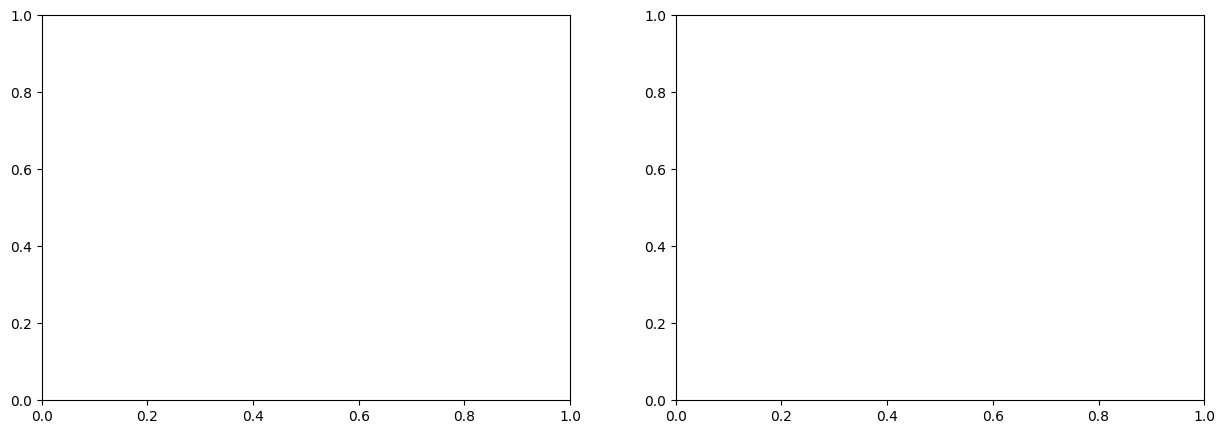

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epoch_train_losses, label='train_loss')
ax[0].plot(epoch_valid_losses, label='valid_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(epoch_train_metric, label='train_metric')
ax[1].plot(epoch_valid_metric, label='valid_metric')
ax[1].legend()
ax[1].set_title('ROC-AUC')
plt.legend()
plt.show()
# plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/loss_ROCAUC_cls.png')


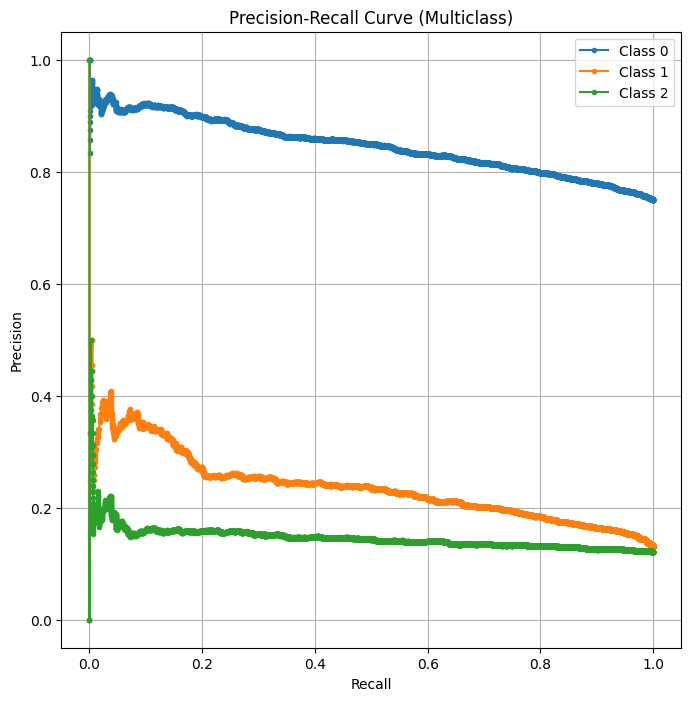

<Figure size 640x480 with 0 Axes>

In [ ]:
from torchmetrics.classification import PrecisionRecallCurve

num_classes = 3  
pr_curve = PrecisionRecallCurve(task="multiclass", num_classes=num_classes).to(device)

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)

        probs = torch.softmax(outputs, dim=1) 

        all_labels.extend(labels.cpu().numpy()) 
        all_probs.extend(probs.cpu().numpy())


all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

precision, recall, _ = pr_curve(torch.tensor(all_probs), torch.tensor(all_labels))

# Построение графика
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(recall[i].cpu(), precision[i].cpu(), marker='.', label=f'Class {i}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Multiclass)')
plt.legend()
plt.grid()
plt.show()

# Сохранение графика
# plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/pr_curve_cls.png')


In [ ]:
# torch.save(model.state_dict(), 'clf_bert_v1.pth')

## TEST

In [ ]:
n = 10
text = df['Target'][n]
model

ReviewBert(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(29564, 312, padding_idx=0)
        (position_embeddings): Embedding(512, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-2): 3 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312, out_features=312, bi

In [37]:
test_tok = tokenize_texts(text)
test_tok
# test_tok['input_ids']
# test_tok['attention_mask']

NameError: name 'text' is not defined

In [36]:
logits = model(test_tok['input_ids'].to(device), test_tok['attention_mask'].to(device))

NameError: name 'test_tok' is not defined

In [ ]:
logits
prob = torch.softmax(logits, dim=1)

In [ ]:
prob.argmax().item()

0

In [ ]:
text

0

In [ ]:
sentiment_dict = {"Good": 0, "Bad": 1, "Neutral": 2}
reversed_dict = {v: k for k, v in sentiment_dict.items()}
reversed_dict[0]

'Good'

In [34]:
encodings

{'input_ids': tensor([[    2,   313,  1736,  ...,  8863,   548,     3],
        [    2,  3738,  1690,  ..., 11294, 15687,     3],
        [    2,   769, 10705,  ...,  2085,  7673,     3],
        ...,
        [    2,  5880, 11005,  ...,   954,   117,     3],
        [    2,   665,  3448,  ...,  4108, 12815,     3],
        [    2,   341,   753,  ...,   705, 26160,     3]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [44]:
enc = encodings['input_ids'][0]
masl = encodings['attention_mask'][0]
enc, masl

(tensor([    2,   313,  1736,  2698,   117,     1,  6664,   324,  8461,   753,
          9532,   323,   920,  2726, 13197, 19952, 11923,  5880,   548, 10377,
           948,  4159,  1186, 20283, 29125,   313,  1736, 18160,   920,  8811,
           869, 11677, 26629, 11106,  3604,  8484,   815,   866,  6875,  8397,
         11263,   613, 28580,  7084, 23255, 12265,   864,  8863,   548,     3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]))

In [50]:
from sklearn.metrics import f1_score
predict = []
for i in range(len(labels)):
    model.eval()
    enc = encodings['input_ids'][i]
    masl = encodings['attention_mask'][i]
    logi = model(enc.unsqueeze(0).to(device), masl.unsqueeze(0).to(device))
    prob = torch.softmax(logi, dim=1).argmax().item()
    print(prob)
    predict.append(prob)




2
2
0
2
2
2
0
0
2
0
0
0
0
2
0
0
0
0
0
0
0
0
2
0
2
0
0
2
2
0
2
0
2
2
0
2
2
2
2
2
2
2
2
0
2
2
2
0
0
2
2
2
0
2
0
2
0
2
2
0
0
2
0
2
0
2
0
0
2
2
2
0
2
0
2
2
2
2
0
2
2
0
2
2
2
2
0
0
0
0
0
0
0
2
2
2
0
2
0
2
2
2
2
2
2
2
0
0
0
2
2
2
0
0
2
2
0
2
0
0
0
2
0
0
0
0
2
2
2
0
2
2
2
2
0
2
2
2
0
0
2
2
2
0
2
2
0
2
0
2
2
2
2
2
2
2
2
0
2
0
2
2
2
0
0
2
2
2
2
0
0
0
0
0
2
0
2
2
2
2
2
2
0
0
0
2
2
0
0
2
2
2
0
0
2
2
0
0
2
0
2
0
0
0
2
0
0
0
0
2
0
2
2
2
2
2
2
2
0
0
0
2
0
0
0
0
2
0
2
0
2
2
0
0
2
2
2
0
0
0
0
2
0
0
2
0
2
2
2
0
0
0
0
2
2
2
0
0
0
2
2
2
2
0
0
2
2
2
2
2
0
0
2
0
2
2
2
2
0
0
0
2
2
2
0
2
2
0
2
2
0
2
0
2
0
2
0
0
0
2
2
2
2
0
0
2
2
2
0
2
2
2
0
0
2
0
2
0
0
0
0
0
0
0
2
0
0
2
2
0
0
0
2
0
2
2
0
2
2
2
2
0
0
0
2
0
0
0
2
0
2
0
2
2
2
0
2
2
2
0
2
2
2
0
2
0
0
2
0
2
0
0
2
2
0
0
0
2
0
0
0
0
0
0
0
2
2
0
2
2
2
0
0
0
2
2
2
0
2
0
0
2
2
0
0
2
2
0
2
2
2
2
0
2
2
2
0
0
2
0
2
0
2
0
2
2
2
2
0
2
2
0
2
0
2
2
2
2
0
2
2
0
2
2
2
2
0
2
0
2
2
0
0
0
0
2
2
0
2
0
2
2
0
0
2
2
0
0
2
0
2
2
0
0
2
2
0
2
0
2
2
2
2
0
0
0
0
2
2
0
2
2
2
2
2
2
2
0
2
0


KeyboardInterrupt: 